<a href="https://colab.research.google.com/github/palash-21/Rossmann_Stores_Sales_Prediction/blob/main/Rossmann_Stores_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

# 2 Data Preparation 

## 2.1 Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/almabetter pro materials/Capstone Projects/My Capstone Projects/Rossman stores sales prediction/store.csv"
store_df = pd.read_csv(path)

path_r = "/content/drive/MyDrive/Colab Notebooks/almabetter pro materials/Capstone Projects/My Capstone Projects/Rossman stores sales prediction/Rossmann Stores Data.csv"
sales_df = pd.read_csv(path_r, parse_dates = True)

In [ ]:
# have a glance on the datasets
print("no of observations & no of features", sales_df.shape)
sales_df.head()


no of observations & no of features (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales_df['Date'].sort_values()

1017208    2013-01-01
1016473    2013-01-01
1016472    2013-01-01
1016471    2013-01-01
1016470    2013-01-01
              ...    
745        2015-07-31
746        2015-07-31
747        2015-07-31
741        2015-07-31
0          2015-07-31
Name: Date, Length: 1017209, dtype: object

In [ ]:
sales_df['Date'].value_counts()

2015-07-31    1115
2013-11-06    1115
2013-11-18    1115
2013-11-17    1115
2013-11-16    1115
              ... 
2014-10-28     935
2014-10-27     935
2014-10-26     935
2014-10-25     935
2014-12-08     935
Name: Date, Length: 942, dtype: int64

In [ ]:
# Grouping by date
date_grp_df=sales_df.groupby(['Store'])['Date'].count().reset_index().groupby(['Date'])["Store"].count().reset_index()
date_grp_df

,Date,Store
0,758,180
1,941,1
2,942,934


# We have store sales data for 942 days for 934 stores out of 1115 while for 180 stores we only have 758 days of sales data

In [ ]:
# Store open/close
sales_df['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [ ]:
# Lets remove the entries when store was closed 
sales_df = sales_df[sales_df['Open']==1]
sales_df.shape

(844392, 9)

In [ ]:
print("no of observations & no of features", store_df.shape)
store_df.head()

no of observations & no of features (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [ ]:
#Count missing values in each dataset

print("sales_df :\n\n", sales_df.isnull().sum(),  
     "\n\n store_df :\n\n", store_df.isnull().sum())

sales_df :

 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

 store_df :

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [ ]:
store_df[store_df['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
store_df[store_df['CompetitionOpenSinceMonth'].isna()][store_df['CompetitionOpenSinceYear'].isna()].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [ ]:
store_df[store_df['CompetitionOpenSinceMonth'].isna()][store_df['CompetitionOpenSinceYear'].isna()].shape

(354, 10)

In [ ]:
store_df[store_df['CompetitionOpenSinceMonth'].isna()][store_df['CompetitionOpenSinceYear'].isna()].describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,354.000000,351.000000,0.0,0.0,354.000000,206.000000,206.000000
mean,560.584746,5430.854701,NaN,NaN,0.581921,25.480583,2011.567961
std,321.188639,7407.075757,NaN,NaN,0.493941,14.858261,1.638781
min,12.000000,20.000000,NaN,NaN,0.000000,1.000000,2009.000000
25%,277.500000,630.000000,NaN,NaN,0.000000,13.000000,2010.000000
50%,529.000000,2460.000000,NaN,NaN,1.000000,27.000000,2012.000000
75%,852.500000,7900.000000,NaN,NaN,1.000000,40.000000,2013.000000
max,1115.000000,75860.000000,NaN,NaN,1.000000,50.000000,2015.000000


# For features Competetion Open since month,year we dont have data for 354 out of 1115 stores which acoounts to  more than 30% null values. 

In [ ]:
store_df[store_df['Promo2SinceWeek'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
store_df[store_df['Promo2SinceWeek'].isna()].describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,544.000000,544,544,542.000000,396.000000,396.000000,544.0,0.0,0.0,0
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,0
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,313,289,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,555.531250,NaN,NaN,6549.520295,7.260101,2009.123737,0.0,NaN,NaN,NaN
std,317.491536,NaN,NaN,9374.321188,3.176739,4.326819,0.0,NaN,NaN,NaN
min,1.000000,NaN,NaN,30.000000,1.000000,1990.000000,0.0,NaN,NaN,NaN
25%,280.250000,NaN,NaN,992.500000,4.000000,2006.000000,0.0,NaN,NaN,NaN
50%,559.000000,NaN,NaN,2640.000000,8.000000,2010.000000,0.0,NaN,NaN,NaN
75%,827.250000,NaN,NaN,8105.000000,10.000000,2013.000000,0.0,NaN,NaN,NaN


In [ ]:
store_df['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

# For the stores no having promo2 active , naturally the other features like promo2 active since have null values, so we will add a new feature using this info.  

In [ ]:
# removing  features
store_df = store_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1)

Text(0.5, 1.0, 'Distributin of Store Competition Distance')

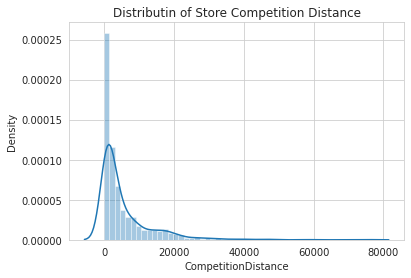

In [ ]:
# CompetitionDistance is distance in meters to the nearest competitor store
# let's first have a look at its distribution
sns.distplot(store_df.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

## Here we'll replace missing values with the median.

In [ ]:
# replace missing values in CompetitionDistance with median for the store dataset
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace=True)


In [ ]:
# Lets merge both the files
df=pd.merge(sales_df,store_df,how='left',on='Store')
df.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,0,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 844391
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844392 non-null  int64  
 1   DayOfWeek            844392 non-null  int64  
 2   Date                 844392 non-null  object 
 3   Sales                844392 non-null  int64  
 4   Customers            844392 non-null  int64  
 5   Open                 844392 non-null  int64  
 6   Promo                844392 non-null  int64  
 7   StateHoliday         844392 non-null  object 
 8   SchoolHoliday        844392 non-null  int64  
 9   StoreType            844392 non-null  object 
 10  Assortment           844392 non-null  object 
 11  CompetitionDistance  844392 non-null  float64
 12  Promo2               844392 non-null  int64  
 13  Promo2SinceWeek      421085 non-null  float64
 14  Promo2SinceYear      421085 non-null  float64
 15  PromoInterval    

In [ ]:
df['Date'][2000]

'2015-07-30'

In [ ]:
datetime.datetime.strptime(df['Date'][2000],'%Y-%m-%d').date().isocalendar()[1]

31

In [ ]:
# Adding some useful features

def GetYear(date):
  return int(date[:4])

def GetMonth(date):
  return int(date[5:7])

def GetDay(date):
  return int(date[8:])

def GetWeekOfYear(date):
  return  datetime.datetime.strptime(date,'%Y-%m-%d').date().isocalendar()[1]


df['year'] = df['Date'].apply(GetYear)
df['month'] = df['Date'].apply(GetMonth)
df['day'] = df['Date'].apply(GetDay)
df['weekofyear'] = df['Date'].apply(GetWeekOfYear)
df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,NaN,NaN,NaN,2015,7,31,31


In [ ]:
df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear
844387,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,0,NaN,NaN,NaN,2013,1,1,1
844388,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,0,NaN,NaN,NaN,2013,1,1,1
844389,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1
844390,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0,NaN,NaN,NaN,2013,1,1,1
844391,1097,2,2013-01-01,5961,1405,1,0,a,1,b,b,720.0,0,NaN,NaN,NaN,2013,1,1,1


In [ ]:
df[df['Sales']==0].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear
73090,971,5,2015-05-15,0,0,1,0,0,1,c,a,1140.0,1,14.0,2012.0,"Mar,Jun,Sept,Dec",2015,5,15,20
116587,674,4,2015-03-26,0,0,1,0,0,0,a,a,2640.0,1,31.0,2013.0,"Feb,May,Aug,Nov",2015,3,26,13
163494,699,4,2015-02-05,0,0,1,1,0,0,a,a,180.0,1,5.0,2013.0,"Jan,Apr,Jul,Oct",2015,2,5,6
266468,708,3,2014-10-01,0,0,1,1,0,0,c,c,11470.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",2014,10,1,40
273680,357,1,2014-09-22,0,0,1,0,0,0,a,a,2060.0,0,NaN,NaN,NaN,2014,9,22,39


In [ ]:
# Making  a copy
df1 = df.copy()

In [ ]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,NaN,NaN,NaN,2015,7,31,31


In [ ]:
df1['PromoInterval'][1]

'Jan,Apr,Jul,Oct'

In [ ]:
df1['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     242411
Feb,May,Aug,Nov      98005
Mar,Jun,Sept,Dec     80669
Name: PromoInterval, dtype: int64

In [ ]:
df1['PromoInterval'] = df1['PromoInterval'].str.split(',')  

In [ ]:
# Converting months into list of month numbers for easy comparison
def GetMonthNumber(month):
  month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}
  return month_dict[month]

def GetNumList(interval):
  numlist=[]
  for month in interval:
    month_num = GetMonthNumber(month)
    numlist.append(month_num)
  return numlist  

In [ ]:
GetNumList(df1['PromoInterval'][1])

[1, 4, 7, 10]

# For some stores sales is zero when open

In [ ]:
# Lets look at promo2
# Lets make a new variable idicating if new round of promo2 is started or not in that month 
promo2new = []
for index,row in df1.iterrows():
  # Initializing a variable
  promo2started = 0
  promo2active = 0
  #if index == 5:
   # break

  if row.Promo2 == 1:
          
    if row.year == row.Promo2SinceYear and row.weekofyear >= row.Promo2SinceWeek :
      promo2started = 1

    elif row.year > row.Promo2SinceYear :
      promo2started = 1

    if promo2started == 1:

      promo_months = GetNumList(row.PromoInterval)
      if row.month in promo_months:
        promo2active = 1

  promo2new.append(promo2active)
  #print(index,promo2active)


In [ ]:
df1['promo2new']=promo2new
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear,promo2new
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,NaN,NaN,2015,7,31,31,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,31,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,31,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,NaN,NaN,NaN,2015,7,31,31,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,NaN,NaN,NaN,2015,7,31,31,0


In [ ]:
df1['promo2new'].value_counts()

0    718104
1    126288
Name: promo2new, dtype: int64

In [ ]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval', 'year', 'month', 'day', 'weekofyear', 'promo2new'],
      dtype='object')

In [ ]:
df1['Customers'].describe()

count    844392.000000
mean        762.728395
std         401.227674
min           0.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

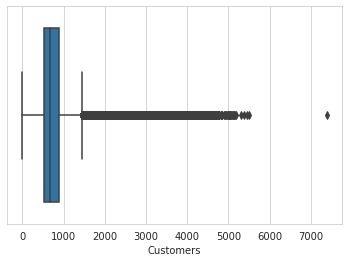

In [ ]:
sns.boxplot(df1['Customers'])

In [ ]:
df1[df1['Customers']>7000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear,promo2new
825213,817,2,2013-01-22,27190,7388,1,1,0,0,a,a,140.0,0,NaN,NaN,NaN,2013,1,22,4,0


In [ ]:
# we will remove this entry as it will create bias 
df1 = df1[df1['Customers']<7000]

In [ ]:
# As we wont be able to use no of customers in test data, we must not use it directly in training, so we will extract some data from it instead 
#def GetAverages(period):

 # average_df = df1.groupby([period])['Customers'].mean().reset_index()

  #return average_df


def GetAverages(period):

  average_df = df1.groupby(['Store',period])['Customers'].mean().reset_index()

  return average_df
  

In [ ]:
weekly_customers_df = GetAverages('weekofyear')
weekly_customers_df.rename(columns={"Customers":'weekly_avg_cust'},inplace=True)
weekly_customers_df

,Store,weekofyear,weekly_avg_cust
0,1,1,604.000000
1,1,2,603.166667
2,1,3,547.777778
3,1,4,570.666667
4,1,5,571.277778
...,...,...,...
57972,1115,48,492.416667
57973,1115,49,532.833333
57974,1115,50,414.250000
57975,1115,51,627.333333


In [ ]:
weekly_customers_df['Store'].value_counts()

1       52
742     52
749     52
748     52
747     52
        ..
370     52
369     52
1115    52
644     51
744     50
Name: Store, Length: 1115, dtype: int64

 # We dnt have data for store 644 for 1 week and store 744 for 2 weeks

In [ ]:
monthly_customers_df = GetAverages('month')
monthly_customers_df.rename(columns={"Customers":'monthly_avg'},inplace=True)
monthly_customers_df

,Store,month,monthly_avg
0,1,1,575.358974
1,1,2,579.194444
2,1,3,594.298701
3,1,4,559.095890
4,1,5,564.169014
...,...,...,...
13375,1115,8,413.679245
13376,1115,9,416.294118
13377,1115,10,409.173077
13378,1115,11,449.058824


In [ ]:
day_of_week_customers_df = GetAverages('DayOfWeek')
day_of_week_customers_df.rename(columns={"Customers":'weekday_avg_cust'},inplace=True)
day_of_week_customers_df

,Store,DayOfWeek,weekday_avg_cust
0,1,1,594.382812
1,1,2,549.440299
2,1,3,542.462121
3,1,4,537.177419
4,1,5,562.248062
...,...,...,...
6718,1115,2,400.895522
6719,1115,3,395.818182
6720,1115,4,405.040323
6721,1115,5,444.263566


In [ ]:
# Adding all these features to thedf
df1 = pd.merge(df1,monthly_customers_df,how='left',on=['Store','month'])
df1 = pd.merge(df1,weekly_customers_df,how='left',on=['Store','weekofyear'])
df1 = pd.merge(df1,day_of_week_customers_df,how='left',on=['Store','DayOfWeek'])
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year,month,day,weekofyear,promo2new,monthly_avg,weekly_avg_cust,weekday_avg_cust
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,NaN,NaN,NaN,2015,7,31,31,0,528.061728,577.294118,562.248062
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,31,1,635.320988,640.176471,562.457364
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,31,1,728.567901,796.705882,787.335938
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,NaN,NaN,NaN,2015,7,31,31,0,1250.407407,1375.117647,1302.565891
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,NaN,NaN,NaN,2015,7,31,31,0,555.567901,595.647059,569.125000



# EDA


In [ ]:
# From Sales correlation with other variables , we get some important features like Promo,weekly avg cust, weekday avg cust, day of week, promo2,promo2new,monthly avg cust
corr = df1.drop(columns=["Customers",'Open']).corr()
corr['Sales']

Store                  0.007704
DayOfWeek             -0.178734
Sales                  1.000000
Promo                  0.368146
SchoolHoliday          0.038621
CompetitionDistance   -0.035846
Promo2                -0.127591
Promo2SinceWeek        0.095311
Promo2SinceYear       -0.034713
year                   0.036178
month                  0.073613
day                   -0.051855
weekofyear             0.074485
promo2new             -0.065479
monthly_avg            0.660229
weekly_avg_cust        0.700837
weekday_avg_cust       0.700721
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Correlation Heatmap')

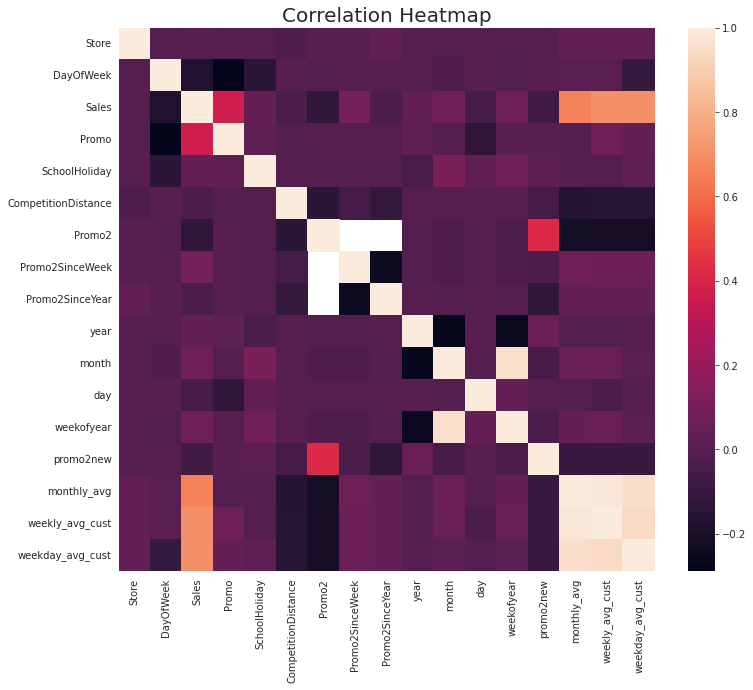

In [ ]:
# Heatmap
f,ax = plt.subplots(figsize = (12,10))
sns.heatmap(corr)
plt.title("Correlation Heatmap", fontsize=20)

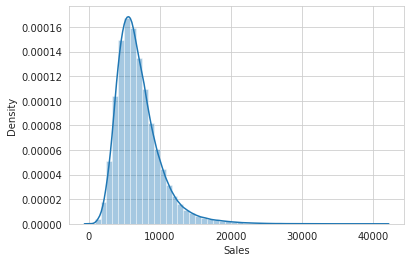

In [ ]:
# Lets look at our dependant variable
sns.distplot(df1['Sales'])

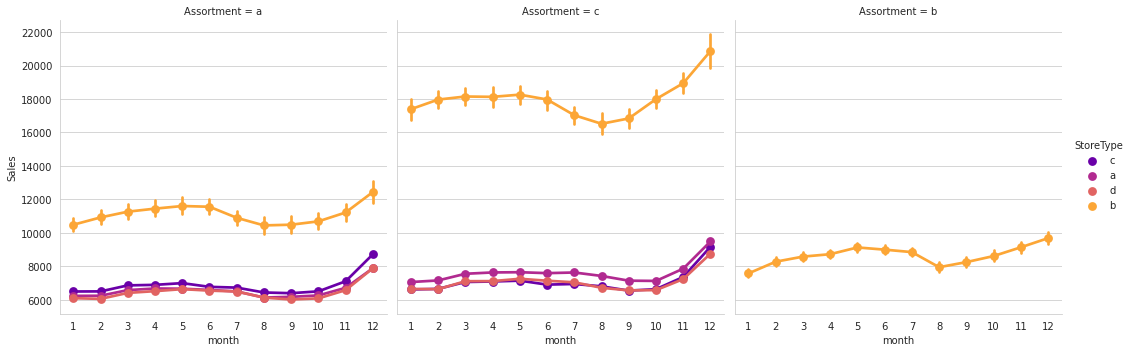

In [ ]:
sns.factorplot(data = df, x = 'month', y = "Sales", 
               col = 'Assortment',
               palette = 'plasma',
               hue = 'StoreType')

# Store type b and assortment c has highest sales

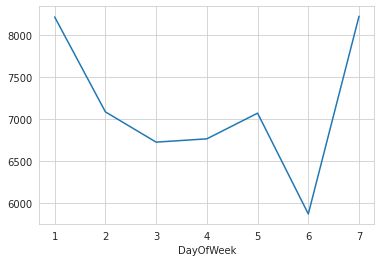

In [ ]:
# Week-days-wise sales
df1.groupby('DayOfWeek')['Sales'].mean().plot()

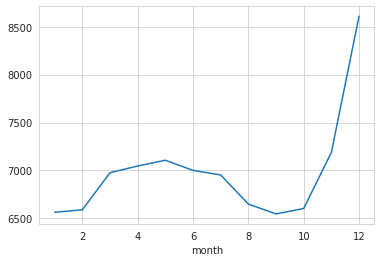

In [ ]:
# Monthly Sales
df1.groupby('month')['Sales'].mean().plot()

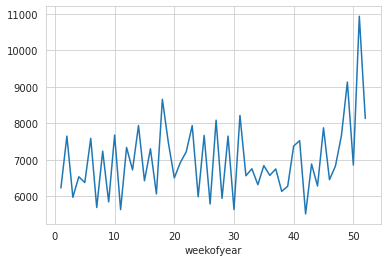

In [ ]:
# Week of the year vs Sales
df1.groupby('weekofyear')['Sales'].mean().plot()

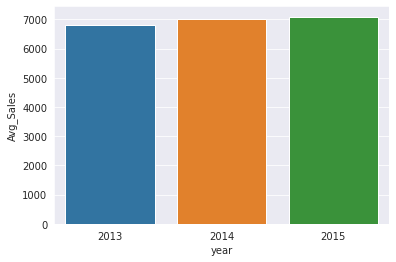

In [ ]:
# Year vs sales
year_wise_sales_df = df1.groupby('year')['Sales'].mean().reset_index()
year_wise_sales_df.rename(columns={'Sales':'Avg_Sales'},inplace=True)
x=year_wise_sales_df['year']
y=year_wise_sales_df['Avg_Sales']
sns.set_style("darkgrid")
sns.barplot(x=x,y=y)
plt.show()

# Increase in Sales is evident from the graph.

[Text(0.5, 1.0, 'Sales vs Promo')]

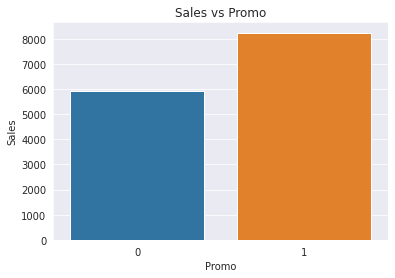

In [ ]:
# Lets see how promo is impacting sales
sns.barplot(x='Promo',y='Sales',data=df1).set(title='Sales vs Promo')

# There is increase in sales due to promo

[Text(0.5, 1.0, 'Sales vs Promo2new')]

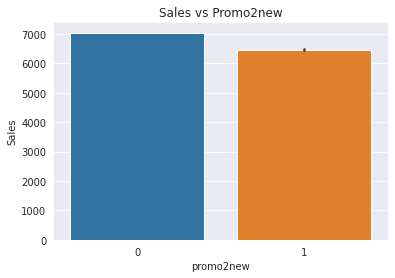

In [ ]:
# Checking the same for when new promo2 is started 
sns.barplot(x='promo2new',y='Sales',data=df1).set(title='Sales vs Promo2new')

# Promo2 doesnt seem much effective

In [ ]:
# Stateholiday vs Sales


[Text(0.5, 1.0, 'School Holiday vs Sales')]

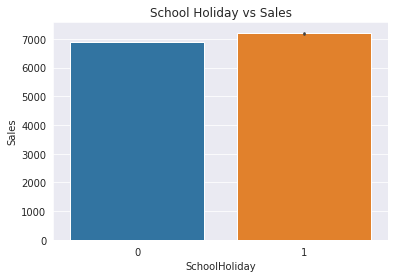

In [ ]:
# Sales with respect to School Holiday
sns.barplot(x='SchoolHoliday', y='Sales', data=df1).set(title='School Holiday vs Sales')

# Sales is higher on school holidays

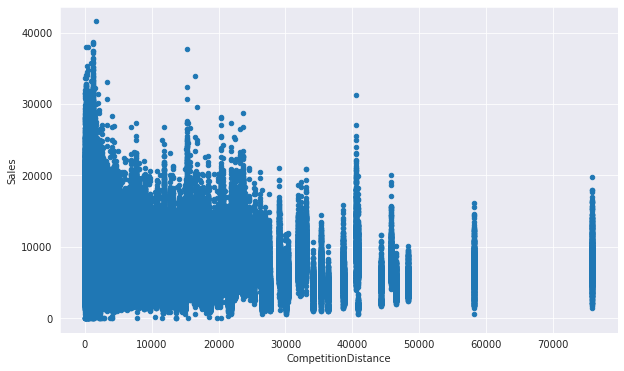

In [ ]:
# Competetion distance
df1.plot(x='CompetitionDistance',y='Sales',kind='scatter',figsize =(10,6))

# Even when competatiors are near, sales are higher in rossman stores

# Feature selection

In [ ]:
#dropping  columns that are not needed
df1.drop(columns=['Date','Open','Promo2SinceWeek','Promo2SinceYear','PromoInterval',"Customers"],inplace=True)

# Categorical

In [ ]:
# Lets look at the categorical features
df1['StateHoliday'].value_counts()

0    731341
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [ ]:
# Converting all number 0 to string '0' for no holiday
df1['StateHoliday'][df1['StateHoliday']==0] = '0'

In [ ]:
df1['StoreType'].value_counts()

a    457076
d    258774
c    112978
b     15563
Name: StoreType, dtype: int64

In [ ]:
df1['Assortment'].value_counts()

a    444908
c    391271
b      8212
Name: Assortment, dtype: int64

In [ ]:
# One hot encoding for categorical features
df1=pd.concat([df1,pd.get_dummies(df1['StateHoliday'],prefix='holy')],axis=1).drop(['StateHoliday'],axis=1)
df1=pd.concat([df1,pd.get_dummies(df1['StoreType'],prefix='type')],axis=1).drop(['StoreType'],axis=1)
df1=pd.concat([df1,pd.get_dummies(df1['Assortment'],prefix='assort')],axis=1).drop(['Assortment'],axis=1)
df1.head()

,Store,DayOfWeek,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,year,month,day,weekofyear,promo2new,monthly_avg,weekly_avg_cust,weekday_avg_cust,holy_0,holy_a,holy_b,holy_c,type_a,type_b,type_c,type_d,assort_a,assort_b,assort_c
0,1,5,5263,1,1,1270.0,0,2015,7,31,31,0,528.061728,577.294118,562.248062,1,0,0,0,0,0,1,0,1,0,0
1,2,5,6064,1,1,570.0,1,2015,7,31,31,1,635.320988,640.176471,562.457364,1,0,0,0,1,0,0,0,1,0,0
2,3,5,8314,1,1,14130.0,1,2015,7,31,31,1,728.567901,796.705882,787.335938,1,0,0,0,1,0,0,0,1,0,0
3,4,5,13995,1,1,620.0,0,2015,7,31,31,0,1250.407407,1375.117647,1302.565891,1,0,0,0,0,0,1,0,0,0,1
4,5,5,4822,1,1,29910.0,0,2015,7,31,31,0,555.567901,595.647059,569.125000,1,0,0,0,1,0,0,0,1,0,0


In [ ]:
df1.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'year', 'month', 'day', 'weekofyear',
       'promo2new', 'monthly_avg', 'weekly_avg_cust', 'weekday_avg_cust',
       'holy_0', 'holy_a', 'holy_b', 'holy_c', 'type_a', 'type_b', 'type_c',
       'type_d', 'assort_a', 'assort_b', 'assort_c'],
      dtype='object')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844391 entries, 0 to 844390
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                844391 non-null  int64  
 1   DayOfWeek            844391 non-null  int64  
 2   Sales                844391 non-null  int64  
 3   Promo                844391 non-null  int64  
 4   SchoolHoliday        844391 non-null  int64  
 5   CompetitionDistance  844391 non-null  float64
 6   Promo2               844391 non-null  int64  
 7   year                 844391 non-null  int64  
 8   month                844391 non-null  int64  
 9   day                  844391 non-null  int64  
 10  weekofyear           844391 non-null  int64  
 11  promo2new            844391 non-null  int64  
 12  monthly_avg          844391 non-null  float64
 13  weekly_avg_cust      844391 non-null  float64
 14  weekday_avg_cust     844391 non-null  float64
 15  holy_0           

# Outliers

In [ ]:
# Zero sales when store is open
df1[df1['Sales'] ==0]['Sales'].count()

54

In [ ]:
#Removing these entries as it may create bias in model
df1 = df1[df1['Sales']>0]

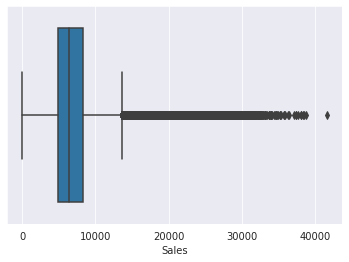

In [ ]:
# Sales outliers
sns.boxplot(df1['Sales'])

In [ ]:
Q1 = np.percentile(df1.Sales, 25) 
Q3 = np.percentile(df1.Sales, 75) 
    
IQR = Q3 - Q1

sales_lower_outlier_cnt = df1[df1['Sales']< (Q1 - 1.5 * IQR)]['Sales'].count()
sales_upper_outlier_cnt = df1[df1['Sales']> (Q3 + 1.5 * IQR)]['Sales'].count()

print('Q1', ':' , Q1 , 'Q3' , ':' , Q3, 'Lower_boundary' , ':' , Q1 - 1.5 * IQR, "Upper_Boundary" , ': ' , Q3 + 1.5 * IQR,
      'lower_outlier_count', ':', sales_lower_outlier_cnt,'upper_outlier_count', ':', sales_upper_outlier_cnt)

Q1 : 4859.0 Q3 : 8360.0 Lower_boundary : -392.5 Upper_Boundary :  13611.5 lower_outlier_count : 0 upper_outlier_count : 30768


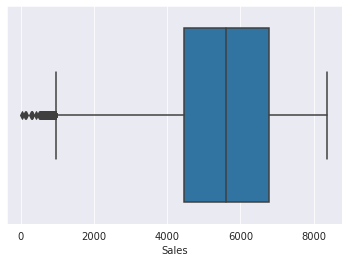

In [ ]:
# Removing outliers and creating a new df
df2 = df1[df1['Sales']<= Q3]
sns.boxplot(df2['Sales'])

# Model selection

In [ ]:
X = df1.drop(columns='Sales')
y=df1['Sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1,test_size=0.3)
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

# Linear Regression

In [ ]:
lr_model= LinearRegression()
lr = lr_model.fit(X_train_std, y_train)

In [ ]:
y_train_pred_lr = lr.predict(X_train_std)
y_pred_lr = lr.predict(X_test_std)

In [ ]:
def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

In [ ]:
lr_y_train_rmse = rmse(y_train, y_train_pred_lr)
lr_y_test_rmse = rmse(y_test, y_pred_lr)
lr_y_train_r2_score = r2_score(y_train, y_train_pred_lr)
lr_y_test_r2_score = r2_score(y_test, y_pred_lr)

print("Training RMSE", ":", lr_y_train_rmse ,
      "Testing RMSE", ":",lr_y_test_rmse )
print("Training R2_Score", ":", lr_y_train_r2_score,
      "Testing R2_Score", ":",lr_y_test_r2_score)

Training RMSE : 1651.7277043363333 Testing RMSE : 1643.9765817905218
Training R2_Score : 0.7172428537787345 Testing R2_Score : 0.7183900155261103


Text(0, 0.5, 'Predicted values')

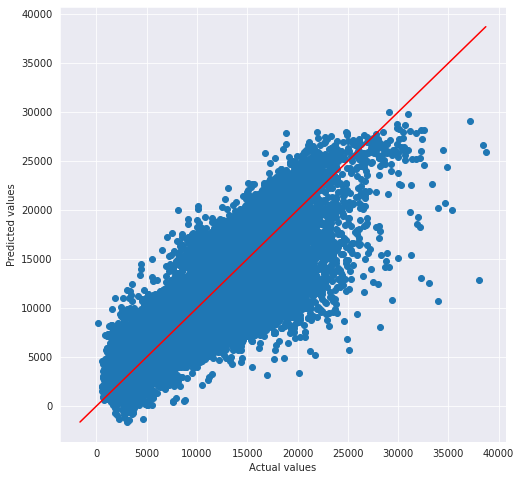

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,y_pred_lr)

p1 = max(max(y_pred_lr),max(y_test))
p2 = min(min(y_pred_lr),min(y_test))
plt.plot([p1,p2],[p1,p2],c='r')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(min_samples_leaf=20)
tree= dt_model.fit(X_train_std, y_train)

In [ ]:
y_train_pred_tree = tree.predict(X_train_std)
y_pred_tree = tree.predict(X_test_std)

In [ ]:
tree_y_train_rmse = rmse(y_train, y_train_pred_tree)
tree_y_test_rmse = rmse(y_test, y_pred_tree)
tree_y_train_r2_score = r2_score(y_train, y_train_pred_tree)
tree_y_test_r2_score = r2_score(y_test, y_pred_tree)

print("Training RMSE", ":", tree_y_train_rmse ,
      "Testing RMSE", ":",tree_y_test_rmse )
print("Training R2_Score", ":", tree_y_train_r2_score,
      "Testing R2_Score", ":",tree_y_test_r2_score)

Training RMSE : 935.3693335642199 Testing RMSE : 1053.7271308593083
Training R2_Score : 0.9093217901223678 Testing R2_Score : 0.8843053918562145


Text(0, 0.5, 'Predicted values')

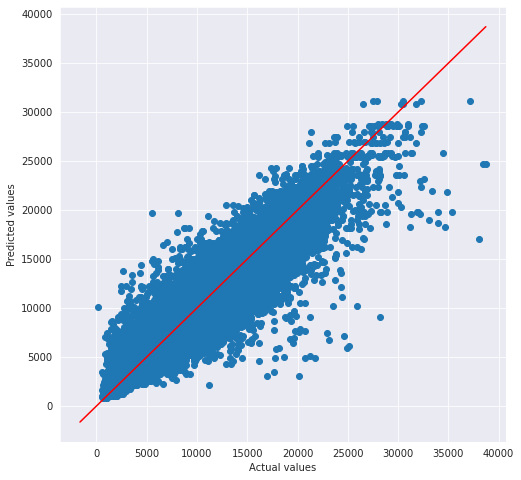

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_test,y_pred_tree)
p1 = max(max(y_pred_lr),max(y_test))
p2 = min(min(y_pred_lr),min(y_test))
plt.plot([p1,p2],[p1,p2],c='r')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Decision Tree has given better results